In [32]:
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from images.paths import DATA_DIR, MODELS_DIR
import requests
import zipfile
import io
import os
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from images.analytics import (
    get_all_image_sizes,
    calculate_average_size,
    count_images_per_class,
    plot_training_and_validation,
    one_hot_encode,
    plot_training_validation_curves,
    visualize_predictions
)

import images.config as cfg
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory


%matplotlib inline

In [2]:
# Check if MPS is available
if tf.config.list_physical_devices('GPU'):
    print("MPS backend is available and will be used.")
else:
    print("MPS backend is not available. Using CPU instead.")

MPS backend is available and will be used.


In [3]:
# Define the batch size and image size
img_size = cfg.IMAGE_SIZE # (255, 255)
batch_size = cfg.BATCH_SIZE # 32
num_classes = cfg.NUM_CLASSES # 4

num_images = cfg.NUM_IMAGES
validation_split = cfg.VALIDATION_SPLIT # 0.25
seed = cfg.SEED # 1234

learning_rate = cfg.LEARNING_RATE # 0.001
epochs = cfg.EPOCHS # 50

In [4]:
# Define the URL and the output directory
url = "https://www.dropbox.com/scl/fi/hzlgwcfavzqmhpylkzuw7/weather.zip?rlkey=m440ako3hlavp8b6jyu0skti9&st=mt7bv32e&dl=1"
extract_dir = DATA_DIR
data_dir = f'{DATA_DIR / "weather"}'

In [5]:
# Download and extract the ZIP file
response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(extract_dir)
    folder_name = os.path.basename(extract_dir)
    print(f"Data extracted to {folder_name}")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

Data extracted to data


In [6]:
# Paths to the folders
folders = [
    f'{data_dir}/cloudy',
    f'{data_dir}/rain',
    f'{data_dir}/shine',
    f'{data_dir}/sunrise'
]

# Execute the collection of sizes
all_image_sizes = get_all_image_sizes(folders)

In [7]:
# Calculate the average size
average_size = calculate_average_size(all_image_sizes)
print(f"Average Image size: Width: {average_size[0]:.0f} pixels, Height: {average_size[1]:.0f} pixels")

Average Image size: Width: 506 pixels, Height: 335 pixels


In [8]:
# Load the training dataset
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 1125 files belonging to 4 classes.
Using 844 files for training.


2024-09-08 02:04:15.217330: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-08 02:04:15.217358: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-08 02:04:15.217367: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-08 02:04:15.217392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-08 02:04:15.217414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 1125 files belonging to 4 classes.
Using 281 files for validation.


In [10]:
# Print class names
class_names = train_dataset.class_names
print(f'Classes: {class_names}')

Classes: ['cloudy', 'rain', 'shine', 'sunrise']


In [11]:
# Count images per class in training and validation datasets
train_class_counts = count_images_per_class(train_dataset)
validation_class_counts = count_images_per_class(validation_dataset)

# Print the class distribution for the training dataset
print(f"Training dataset class distribution: {train_class_counts}")

# Print the class distribution for the validation dataset
print(f"Validation dataset class distribution: {validation_class_counts}")

2024-09-08 02:04:15.886067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training dataset class distribution: {1: 153, 0: 239, 3: 270, 2: 182}
Validation dataset class distribution: {3: 87, 1: 62, 2: 71, 0: 61}


2024-09-08 02:04:16.098032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# Inspect a few batches
for images, labels in train_dataset.take(1):
    print("Training batch labels:", labels.numpy())

for images, labels in validation_dataset.take(1):
    print("Validation batch labels:", labels.numpy())

Training batch labels: [0 2 0 3 3 3 0 0 3 0 3 3 0 2 0 3 3 1 0 2 1 3 0 3 3 0 3 3 3 1 0 1]
Validation batch labels: [1 3 1 2 1 3 3 1 0 3 1 3 3 3 2 1 0 0 2 0 3 3 1 1 0 3 0 3 2 3 2 0]


2024-09-08 02:04:16.483668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-08 02:04:16.592568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-09-08 02:04:16.871307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-08 02:04:17.071114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


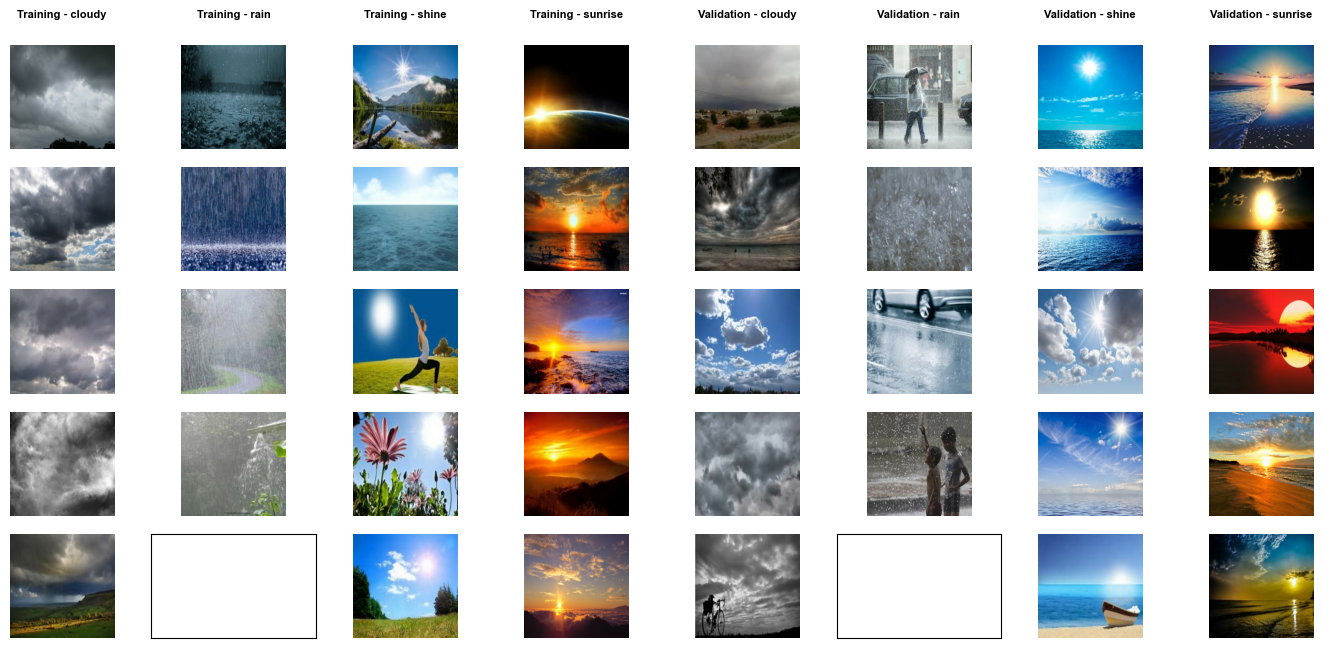

In [13]:
# Plot the training and validation datasets
plot_training_and_validation(train_dataset, validation_dataset, class_names, num_images=num_images)

In [14]:
# One-hot encode the labels
train_dataset = one_hot_encode(train_dataset, num_classes)
validation_dataset = one_hot_encode(validation_dataset, num_classes)

In [15]:
# Define the sequential model
cnn = models.Sequential()

# Add the input layer
cnn.add(layers.Input(shape=(img_size[0], img_size[1], 3)))  # Adjust input_shape according to your data

# # Add data augmentation layer
# cnn.add(data_augmentation)

# Add the layers
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.5))  # Add dropout for regularization
cnn.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Add L2 regularization
cnn.add(layers.Dense(4, activation='softmax'))  # Adjust according to your problem

# Define the RMSprop optimizer with a custom learning rate and other parameters
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=learning_rate,  # initial learning rate = 0.001
)

# Compile the model
cnn.compile(optimizer= optimizer,
              loss='categorical_crossentropy',  # Adjust according to your problem
              metrics=['accuracy'])

# Show the model summary
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,088,452 (49.93 MB)

 Trainable params: 13,088,452 (49.93 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Num_classes
total_samples = sum(train_class_counts.values())

# Calculate class weights for the model
class_weights = {cls: total_samples / (num_classes * train_class_counts.get(cls, 1)) for cls in range(num_classes)}

# Convert to dictionary format
class_weights_dict = {int(cls): float(weight) for cls, weight in class_weights.items()}

# Class weights for verification
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.8828451882845189, 1: 1.3790849673202614, 2: 1.1593406593406594, 3: 0.7814814814814814}


In [17]:
# Train and fit the model
history = cnn.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    class_weight=class_weights_dict, 
    #callbacks=[early_stopping]
)

Epoch 1/50


2024-09-08 02:04:18.297359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.3348 - loss: 385.1116 - val_accuracy: 0.5907 - val_loss: 1.7754
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.5912 - loss: 1.9108 - val_accuracy: 0.5409 - val_loss: 2.6822
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.5632 - loss: 2.6476 - val_accuracy: 0.7616 - val_loss: 1.3660
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.6241 - loss: 2.0188 - val_accuracy: 0.7438 - val_loss: 1.2807
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.6947 - loss: 1.6154 - val_accuracy: 0.6050 - val_loss: 3.3537
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.6433 - loss: 1.8150 - val_accuracy: 0.8221 - val_loss: 0.8975
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.7345 - loss: 1.4490 - val_accuracy: 0.7117 - val_loss: 0.9306
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.7485 - loss: 1.0709 - val_accuracy: 0.6940 - va

In [18]:
# Extract data from the history object
epochs = list(range(1, len(history.history['accuracy']) + 1))
metrics = {
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
}

In [19]:
# Plot evolution of training, validation and loss
plot_training_validation_curves(epochs, metrics)

In [20]:
# Save the trained model
cnn.save(MODELS_DIR / 'cnn2.keras') 

In [21]:
# Load the saved model
tr_model = tf.keras.models.load_model(MODELS_DIR / 'cnn.keras')

In [22]:
# Obtener las predicciones del modelo
y_pred_prob = tr_model.predict(validation_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtener las etiquetas verdaderas
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


2024-09-08 02:10:12.376231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       0.21      0.20      0.20        61
        rain       0.22      0.23      0.22        62
       shine       0.30      0.30      0.30        71
     sunrise       0.24      0.24      0.24        87

    accuracy                           0.24       281
   macro avg       0.24      0.24      0.24       281
weighted avg       0.24      0.24      0.24       281



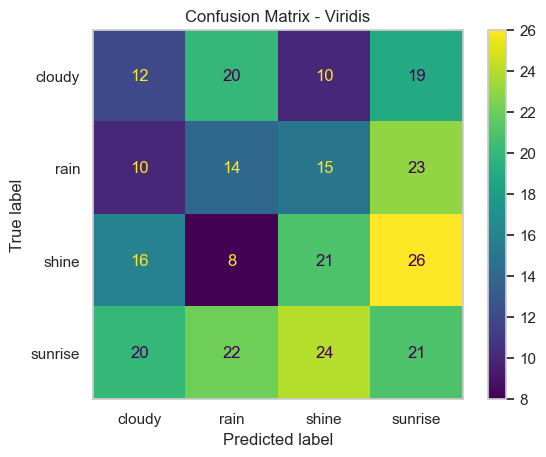

In [24]:
# Visualize the confusion matrix with different colormaps
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Using the 'viridis' colormap
disp.plot(cmap=plt.cm.viridis)
plt.title('Confusion Matrix - Viridis')
plt.gca().images[-1].set_interpolation('nearest')
plt.grid(False)  # Disable the grid
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


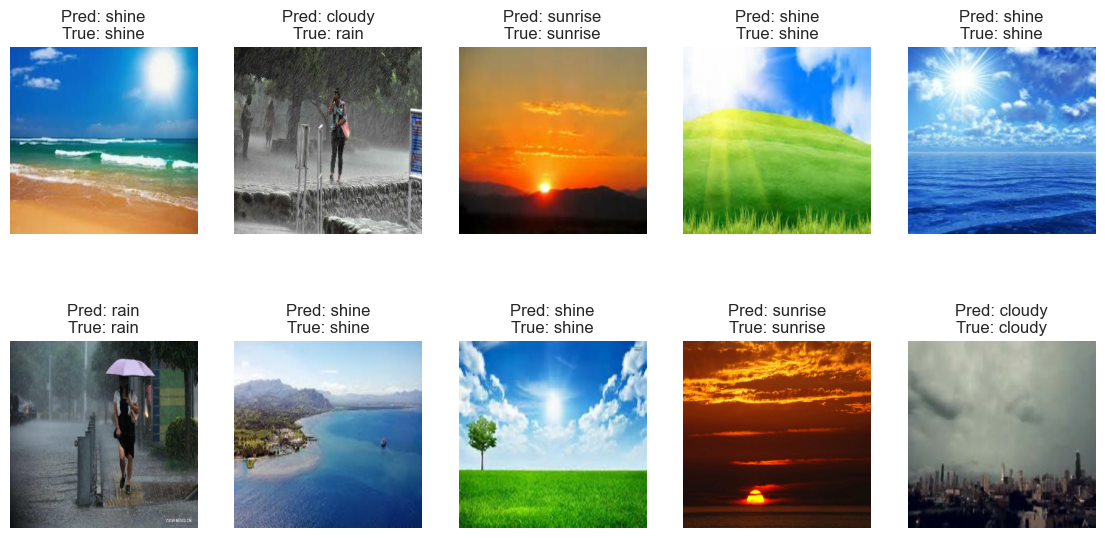

In [33]:
# Visualize 10 unseen pictures to test the model
visualize_predictions(cnn, validation_dataset, class_names)